In [1]:
import shlex
import subprocess
import re
import os

import seaborn as sns
import pandas as pd

In [2]:
class TestResult:
    def __init__(self, file, original_size, compressed, yuv, m, operation, time_taken):
        self.file = file
        self.original_size = original_size
        self.compressed = compressed
        self.yuv = yuv
        self.m = m
        self.operation = operation
        self.time_taken = time_taken

In [3]:
test_files_dir = "tests/resource/"
test_files = [
    "akiyo_qcif.y4m",
    "ducks_take_off_444_720p50.y4m",
    "in_to_tree_444_720p50.y4m",
    "old_town_cross_444_720p50.y4m",
    "park_joy_444_720p50.y4m",
]
test_files = [
    "akiyo_qcif.y4m",
]
sizes = [os.path.getsize(test_files_dir + file) for file in test_files]

In [4]:
time_pattern = re.compile(r"(\d+\.\d+) seconds")
m_test_range = [2**x for x in range(1, 4)]
yuv_quantization = [(128, 64, 64), (64, 32, 32), (32, 16, 16)]

results = []

In [5]:
for i, file in enumerate(test_files):
    print("Generating graph for file: {}\n\n".format(file))
    ########################################
    encoder = "lossless_hybrid"
    print("Encoder: {}".format(encoder))
    for m in m_test_range:
        print("M: {}".format(m))
        # Encode
        print("Operation: encode")
        command = f"bin/CSLPEncoder -c {encoder} --mode encode -i {test_files_dir + file} -o encode -m {m}"
        p1 = subprocess.Popen(
            args=shlex.split(command),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
        p1.wait()
        if p1.returncode != 0:
            print("Error: {}".format(p1.stdout.read()))
            exit(1)
        result = p1.stdout.read()
        time_taken = time_pattern.search(result.decode("utf-8")).group(1)
        compressed_size = os.path.getsize("encode")
        print("Time taken: {} seconds\n".format(time_taken))
        results.append(TestResult(file, sizes[i], compressed_size, None, m, "encode", time_taken))
        # Decode
        print("Operation: decode")
        command = f"bin/CSLPEncoder -c {encoder} --mode decode -i encode -o decode"
        p2 = subprocess.Popen(
            args=shlex.split(command),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
        p2.wait()
        if p2.returncode != 0:
            print("Error: {}".format(p2.stdout.read()))
            exit(1)
        result = p2.stdout.read()
        time_taken = time_pattern.search(result.decode("utf-8")).group(1)
        print("Time taken: {} seconds\n".format(time_taken))
        results.append(TestResult(file, None, None, None, m, "decode", time_taken))
    ########################################
    encoder = "hybrid"
    print("Encoder: {}".format(encoder))
    for yuv in yuv_quantization:
        print("YUV: {}".format(yuv))
        for m in m_test_range:
            print("M: {}".format(m))
            # Encode
            print("Operation: encode")
            command = f"bin/CSLPEncoder -c {encoder} --mode encode -i {test_files_dir + file} -o encode -m {m} -y {yuv[0]} -u {yuv[1]} -v {yuv[2]}"
            p1 = subprocess.Popen(
                args=shlex.split(command),
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )
            p1.wait()
            if p1.returncode != 0:
                print("Error: {}".format(p1.stdout.read()))
                exit(1)
            result = p1.stdout.read()
            time_taken = time_pattern.search(result.decode("utf-8")).group(1)
            compressed_size = os.path.getsize("encode")
            print("Time taken: {} seconds\n".format(time_taken))
            results.append(TestResult(file, sizes[i], compressed_size, yuv, m, "encode", time_taken))
            # Decode
            print("Operation: decode")
            command = f"bin/CSLPEncoder -c {encoder} --mode decode -i encode -o decode"
            p2 = subprocess.Popen(
                args=shlex.split(command),
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )
            p2.wait()
            if p2.returncode != 0:
                print("Error: {}".format(p2.stdout.read()))
                exit(1)
            result = p2.stdout.read()
            time_taken = time_pattern.search(result.decode("utf-8")).group(1)
            print("Time taken: {} seconds\n".format(time_taken))
            results.append(TestResult(file, None, None, yuv, m, "decode", time_taken))
########################################

Generating graph for file: akiyo_qcif.y4m
Encoder: lossless_hybrid
M: 2
Operation: encode
Time taken: 0.475137 seconds
Operation: decode
Time taken: 0.769867 seconds
M: 4
Operation: encode
Time taken: 0.480998 seconds
Operation: decode
Time taken: 0.732495 seconds
M: 8
Operation: encode
Time taken: 0.567127 seconds
Operation: decode
Time taken: 0.789863 seconds
M: 16
Operation: encode
Time taken: 0.543066 seconds
Operation: decode
Time taken: 0.95434 seconds
Encoder: hybrid
YUV: (255, 255, 255)
M: 2
Operation: encode
Time taken: 1.43117 seconds
Operation: decode
Time taken: 0.650911 seconds
M: 4
Operation: encode
Time taken: 1.51554 seconds
Operation: decode
Time taken: 0.651249 seconds
M: 8
Operation: encode
Time taken: 1.59783 seconds
Operation: decode
Time taken: 0.696775 seconds
M: 16
Operation: encode
Time taken: 1.62215 seconds
Operation: decode
Time taken: 0.769894 seconds
YUV: (128, 128, 128)
M: 2
Operation: encode
Time taken: 1.66696 seconds
Operation: decode
Time taken: 0.581

In [13]:
sns.set_theme(style="whitegrid")
# increase size of plot
sns.set(rc={'figure.figsize':(12, 8)})

Text(0.5, 1.0, 'Compression Ratio vs M (Encode Lossy Hybrid)')

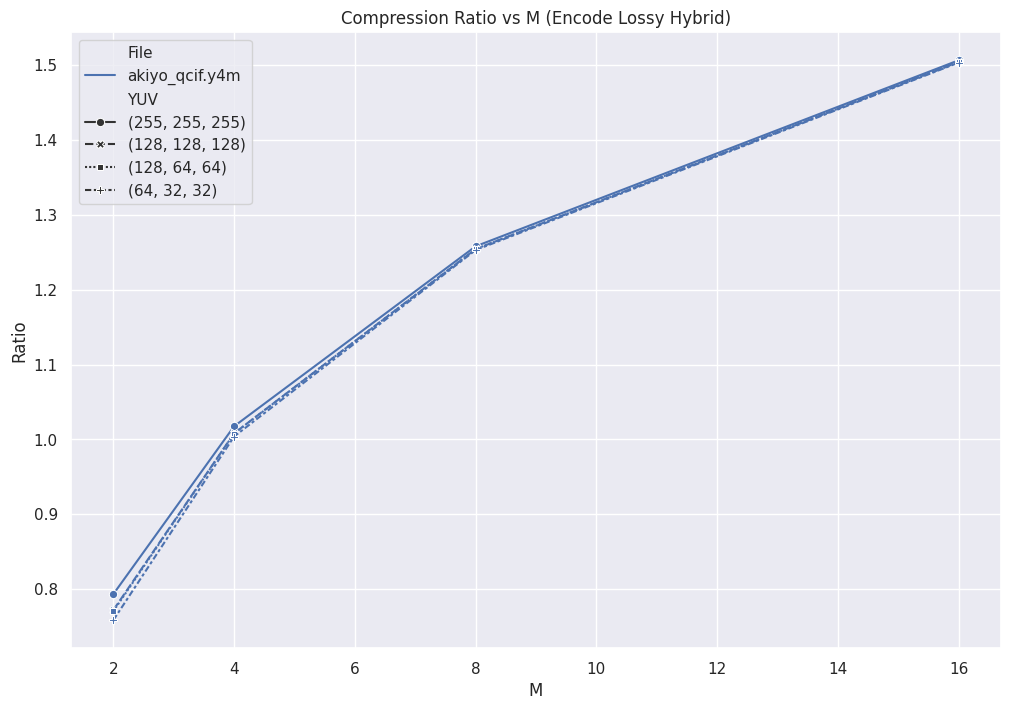

In [21]:
filtered = [result for result in results if result.operation == "encode" and result.yuv is not None]

original_size = [result.original_size for result in filtered]
compressed_size = [result.compressed for result in filtered]
ratio = [result.compressed / result.original_size for result in filtered]

df = pd.DataFrame(
    {
        "Ratio": ratio,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

sns.lineplot(data=df, x="M", y="Ratio", hue="File", style="YUV", markers=True).set_title("Compression Ratio vs M (Encode Lossy Hybrid)")

Text(0.5, 1.0, 'Time Taken vs M (Encode)')

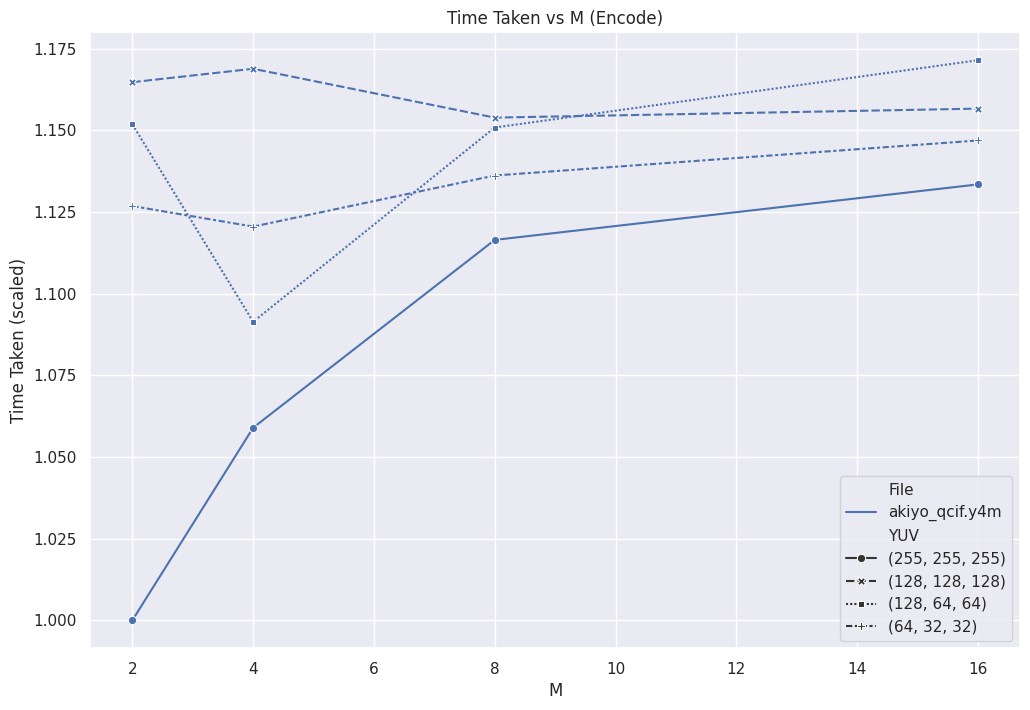

In [25]:
filtered = [result for result in results if result.operation == "encode" and result.yuv is not None]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", style="YUV", markers=True).set_title("Time Taken vs M (Encode)")

In [26]:
filtered = [result for result in results if result.operation == "decode" and result.yuv is not None]

## Time taken adjusted to the fastest time taken for each file
time_taken = [result.time_taken for result in filtered]
time_taken = [float(x) for x in time_taken]
fastest_time_taken = min(time_taken)
time_taken = [x / fastest_time_taken for x in time_taken]

df = pd.DataFrame(
    {
        "Time Taken (scaled)": time_taken,
        "M": [result.m for result in filtered],
        "File": [result.file for result in filtered],
        "YUV": [result.yuv for result in filtered],
    }
)

sns.lineplot(data=df, x="M", y="Time Taken (scaled)", hue="File", style="YUV", markers=True).set_title("Time Taken vs M (Decode)")

ValueError: min() arg is an empty sequence